This Julia 1.5.0 Jupyter notebook provides code and instructions to produce some of the figures in `A shape theorem for exploding sandpiles'.

To download this code, click <a href = "exploding_sandpiles.ipynb">here</a>.

In [283]:
using Plots # for visualization to install type in ] add Plots 

## Exploding sandpiles 

We visualize exploding sandpiles in two dimensions. We first provide 
functions for parallel toppling and then give several examples of its use.

In [284]:
#######################
## Description 
##		computes num_iter parallel topple updates of a sandpile on a square
## Inputs
## 		S: an array of integers specifying the sandpile  
## 		T: an array of integers specifying current odometer  
## 		num_iters: an integer specifying how many parallel update steps to take,
##       if -1, then topple until boundary of cube topples or sandpile is stable
## Output
##      sandpile and odometer S,T are updated in place 

function parallel_topple!(S, T, num_iters)
    topple_end = false;
    if(num_iters == -1)
        topple_end = true;
        num_iters = size(S,1)^3
    end
    for i in 1:num_iters
        S_prev = copy(S)
        for y in 1:size(S,2)
            for x in 1:size(S,1)
                one_topple!(S,S_prev,T,x,y)
            end
        end
        if(topple_end == true)
            if(sum(T[1,:]) > 0 || sum(T[size(T,1),:]) > 0 || sum(T[:,1]) > 0 || sum(T[:,size(T,2)]) > 0) break; end
        end
        if(S == S_prev) break; end #if sandpile is stable
    end
end

## helper function
## fire a single site in S once 
## via the parallel update procedure
function one_topple!(S,S_prev, T,x,y)
    ## now topple according to how many 
    ## grains it had at the PREVIOUS
    ## time step
    z = max(floor(S_prev[x,y]/4), 0) 
    
    #number of times to fire site (x,y)
    #we take max in case there is a hole at (x,y)
    #increment the odometer
    z = min(z,1);
    T[x,y]+=z
    S[x,y]-=4*z; 
    
    #give sand to each neighbor
    if(x > 1)
        S[x-1,y]+=z
    end
    if(x < size(S,1))
        S[x+1,y]+=z
    end
    if(y > 1)
        S[x,y-1]+=z
    end
    if(y < size(S,2))
        S[x,y+1]+=z
    end
end;

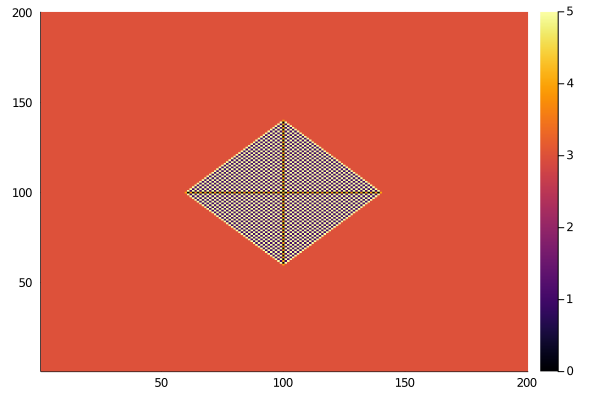

In [285]:
## start with an all 3 background
## add one grain at the origin and parallel topple
## for M steps
N = 200 #size of viewing window
M = 40
S = fill(3,N,N)
T = fill(0,N,N) #initial ondometer
S[div(N,2),div(N,2)]+=1
parallel_topple!(S, T, M)
heatmap(S)

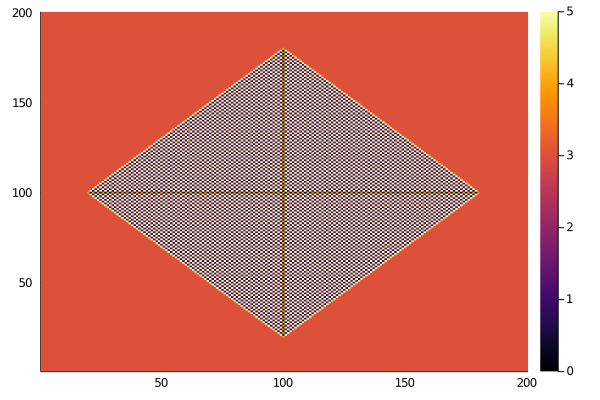

In [286]:
#continue to parallel topple for M more steps
parallel_topple!(S, T, M)
heatmap(S)

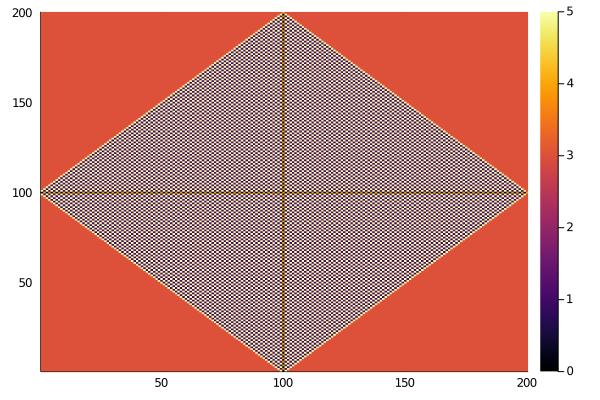

In [287]:
## parallel topple until a site on the boundary topples
## or sandpile is stable 
## (in this case sandpile is exploding so process will stop when it reaches boundary)
parallel_topple!(S, T, -1)
heatmap(S)

This next function automatically puts the minimum number of grains needed at the origin
for the sandpile to reach the boundary of the box (our viewing window of the exploding sandpile). 

In [288]:
#######################
## Description 
##		put enough grains at the origin to cause topplings to reach boundary of the box
##      and compute it
## Inputs
## 		B: an array of integers specifying the background  
## Output
##      exploding sandpile S and parallel toppling odometer T 
##      first time boundary of box is reached

function topple_end_grain(B)
    N1 = size(B,1); N2 = size(B,2)
    for num_grains in 1:(N1^2*N2^2)
        S = copy(B); 
        T = fill(0, size(B))
        S[div(N1,2),div(N2,2)]+=num_grains;
        parallel_topple!(S, T, -1)
        if(sum(T[1,:]) > 0 || sum(T[size(T,1),:]) > 0 || sum(T[:,1]) > 0 || sum(T[:,size(T,2)]) > 0)
            return S,T
        end
    end
end;

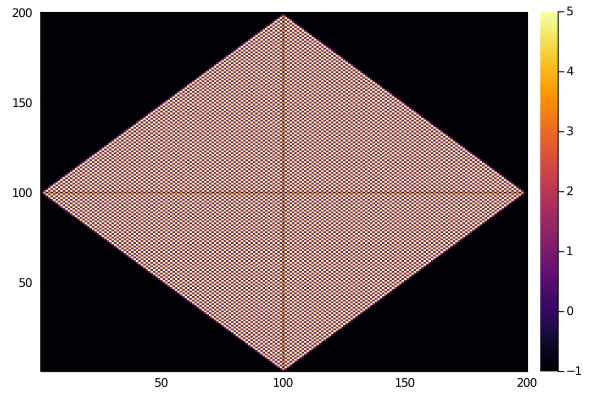

In [289]:
## use above function on the same example as before
N = 200
B = fill(3,N,N)
S,T = topple_end_grain(B)
S[T.==0].=-1; #color sites which haven't toppled differently
heatmap(S)

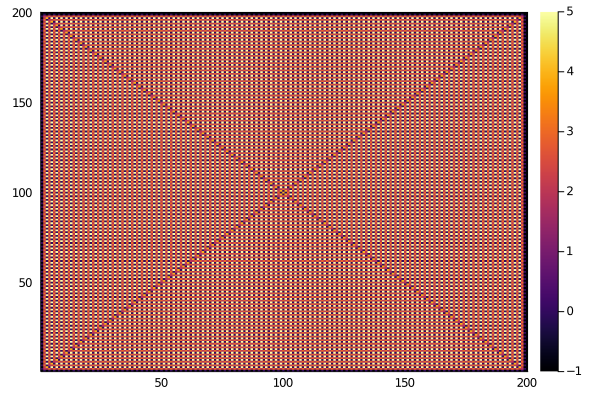

In [290]:
#2,3 checkerboard background
N = 200 
B = [2+(x+y)%2 for x in 1:N, y in 1:N] #checkerboard background
S,T = topple_end_grain(B)
S[T.==0].=-1; #color sites which haven't toppled differently
heatmap(S)

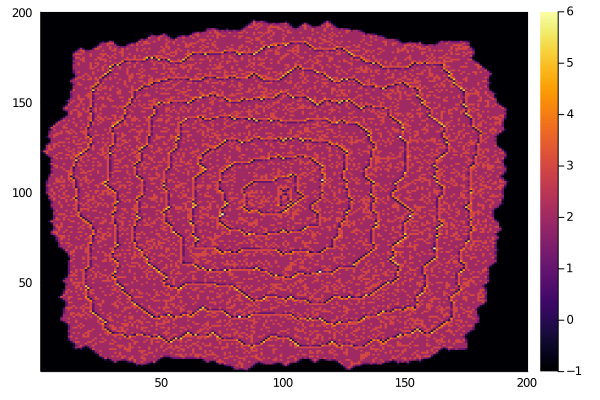

In [291]:
#Bernoulli(2,3,p) background
p = 1/4
N = 200 #size of viewing window
B = 2 .+ 1 .* (rand(N,N).<p)
S,T = topple_end_grain(B)
S[T.==0].=-1; #color sites which haven't toppled differently
heatmap(S)

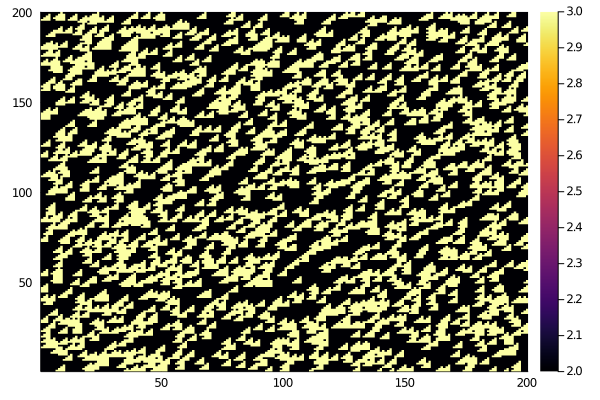

In [292]:
## `Bernoulli cloud' (defined in Section 5 of paper)
N = 200
K = 2
B = fill(2,N,N)
p = 1/20
for x in 1:N 
    for y in 1:N 
       if(rand() < p)
          #fill in a fixed point set
            for e1 in -K:K
                for e2 in -K:K
                    xx = x + e1
                    yy = y + e2
                    if(xx >= 1 && yy >= 1 && xx <= N && yy <= N)
                       if(e2 > e1)
                            B[xx,yy]=3
                        end
                    end
                end
            end
        end
    end
end
heatmap(B) # initial background

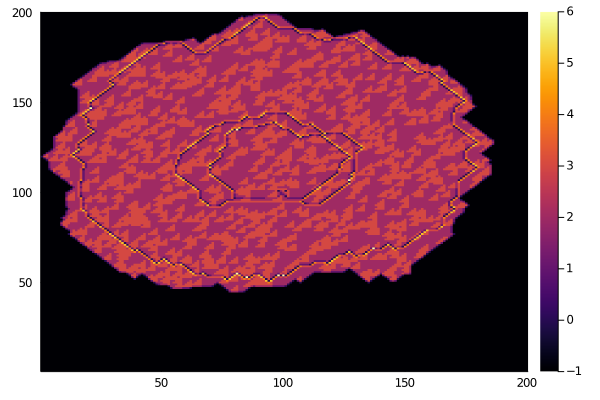

In [293]:
S,T = topple_end_grain(B)
S[T.==0].=-1; #color sites which haven't toppled differently
heatmap(S)

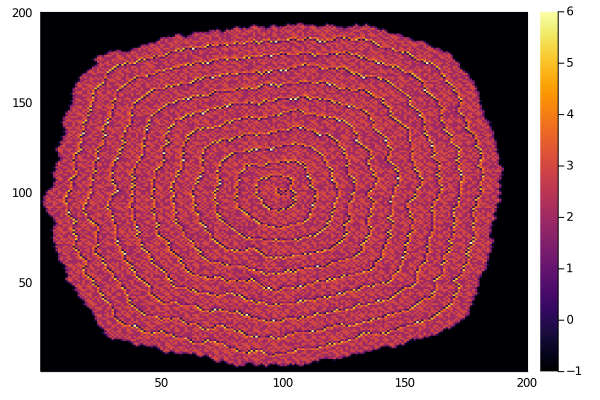

In [294]:
## random checkerboard exploding sandpile (terminology from Section 5 of the paper)
N = 200
B = fill(0,N,N)
box1 = [3 3 2 3; 3 2 3 2; 2 2 3 3 ; 3 3 2 2]
box2 = [2 2 2 2; 2 2 2 2; 2 3 2 2 ; 2 2 3 2]
p = 3/4

for x in 1:N 
    for y in 1:N 
        xx = (x)%4+1;
        yy = (y)%4+1;
        if(rand() < p)
            B[x,y] = box1[xx,yy]
        else
            B[x,y] = box2[xx,yy]
        end
    end
end
S,T = topple_end_grain(B)
S[T.==0].=-1;
heatmap(S)

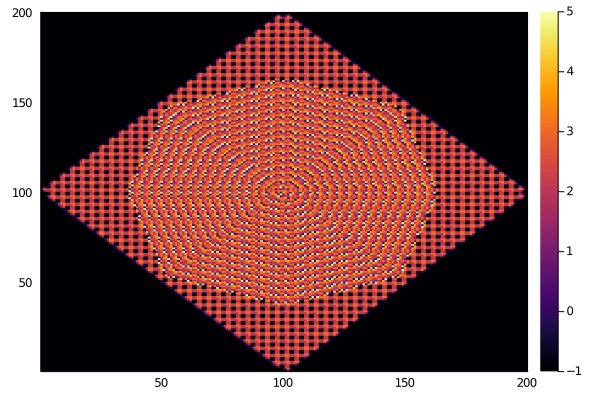

In [295]:
## random checkerboard COUNTEREXAMPLE from Section 6 of the paper
N = 200; #if this number is changed make sure 1 is at the origin!
B = fill(0,N,N)
box1 = [1 3 3 1; 3 3 3 3; 3 3 3 3; 1 3 3 1]
box2 = [1 3 3 1; 3 2 3 3; 3 3 3 3; 1 3 3 1]
p = 1/3 # probability of box1

for x in 1:N 
    for y in 1:N 
        xx = (x)%4+1;
        yy = (y)%4+1;
        if(rand() < p)
            B[x,y] = box1[xx,yy]
        else
            B[x,y] = box2[xx,yy]
        end
    end
end
S,T = topple_end_grain(B)
S[T.==0].=-1;
heatmap(S)

## Last-wave 

We visualize the last-wave of exploding sandpiles in two-dimensions. 
In order to do this, we modify the above code to allow for `freezing' of certain sites

In [296]:
#######################
## Description 
##		computes num_iter parallel topple updates of A-frozen parallel toppling
## Inputs
## 		S: an array of integers specifying the sandpile  
## 		T: an array of integers specifying initial odometer  
##      if S[x,y] = 999, site x,y is frozen and does not topple
## 		num_iters: an integer specifying how many parallel update steps to take,
##       if -1, then topple until boundary of cube topples 
## Output
##      odometer T is updated in place 

function parallel_topple_freeze!(S, T, num_iters)
    topple_end = false;
    if(num_iters == -1)
        topple_end = true;
        num_iters = size(S,1)^3
    end
    T_prev = copy(T); 
    for i in 1:num_iters
        copyto!(T_prev, T) 
        for y in 1:size(S,2)
            for x in 1:size(S,1)
                if(S[x,y] == 999) continue; end
                one_topple_freeze!(T, T_prev,S,x,y)
            end
        end
        if(topple_end == true)
            if(sum(T[1,:]) > 0 || sum(T[size(T,1),:]) > 0 || sum(T[:,1]) > 0 || sum(T[:,size(T,2)]) > 0) break; end
        end
        if(T == T_prev) break; end
    end
end
    
## helper for above
## parallel topple update
function one_topple_freeze!(T, T_prev,S,x,y)
    #update according to the definition of last-wave
    z = S[x,y]
    if(x > 1)
        z = z + T_prev[x-1,y]; 
    end
    if(x < size(S,1))
        z = z + T_prev[x+1,y]
    end
    if(y > 1)
        z = z + T_prev[x,y-1]
    end
    if(y < size(S,2))
        z = z + T_prev[x,y+1]
    end
    z = max(z,0); #in case S is negative bad
    z = floor(Int, z/4);
    T[x,y] = z;     
end

#######################
## Description 
##		topple origin enough times to cause wave to reach boundary of the box
## Inputs
## 		B: an array of integers specifying the background  
## Output
##      last wave odometer first time it hits boundary of box

function topple_end_wave(B)
    N1 = size(B,1); N2 = size(B,2)
    for num_topples in 1:(N1^2*N2^2)
        S = copy(B); 
        T = fill(0, size(B))
        S[div(N1,2),div(N2,2)]=999;
        T[div(N1,2), div(N2,2)]=num_topples
        parallel_topple_freeze!(S, T, -1)
        if(sum(T[1,:]) > 0 || sum(T[size(T,1),:]) > 0 || sum(T[:,1]) > 0 || sum(T[:,size(T,2)]) > 0)
            return T
        end
    end
    end;

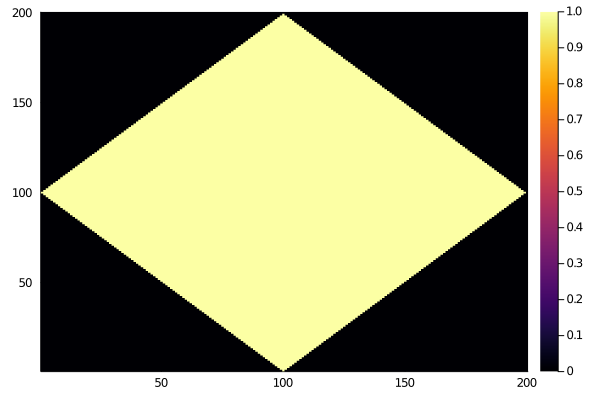

In [297]:
## compute last wave for all 3s background
N = 200
B = fill(3,N,N)
T = topple_end_wave(B)
heatmap(T)

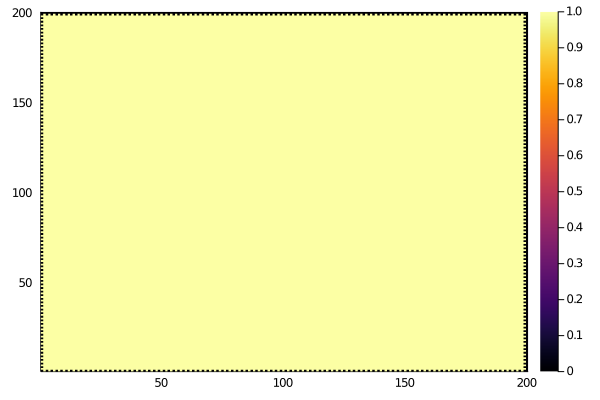

In [298]:
## compute last wave for checkerboard 2,3 background
N = 200
B = [2+(x+y)%2 for x in 1:N, y in 1:N] #checkerboard background
T = topple_end_wave(B)
heatmap(T)

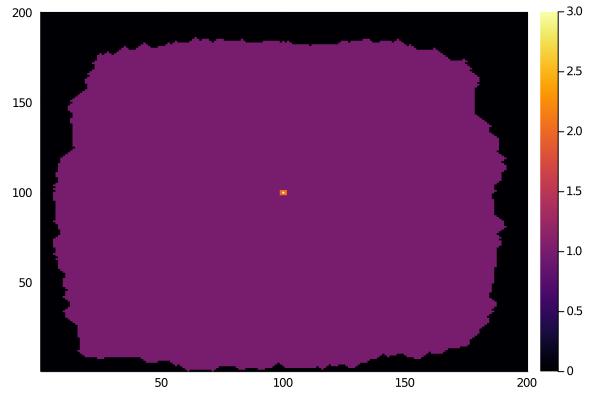

In [299]:
#Bernoulli(2,3,p) background
p = 1/4
N = 200 #size of viewing window
B = 2 .+ 1 .* (rand(N,N).<p)
T = topple_end_wave(B)
heatmap(T)

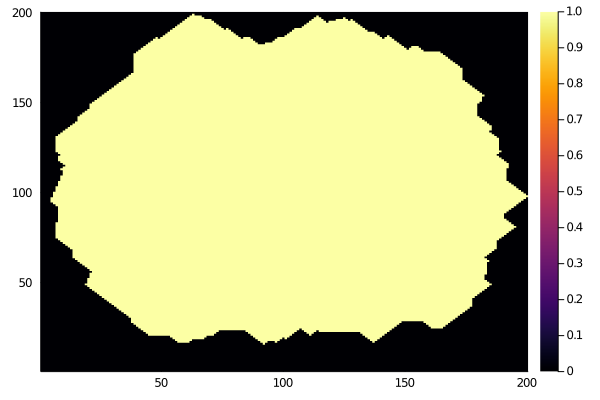

In [300]:
## `Bernoulli cloud' from above
N = 200
K = 2
B = fill(2,N,N)
p = 1/20
for x in 1:N 
    for y in 1:N 
       if(rand() < p)
          #fill in a fixed point set
            for e1 in -K:K
                for e2 in -K:K
                    xx = x + e1
                    yy = y + e2
                    if(xx >= 1 && yy >= 1 && xx <= N && yy <= N)
                       if(e2 > e1)
                            B[xx,yy]=3
                        end
                    end
                end
            end
        end
    end
end
T = topple_end_wave(B)
heatmap(T.>0)#support of the odometer

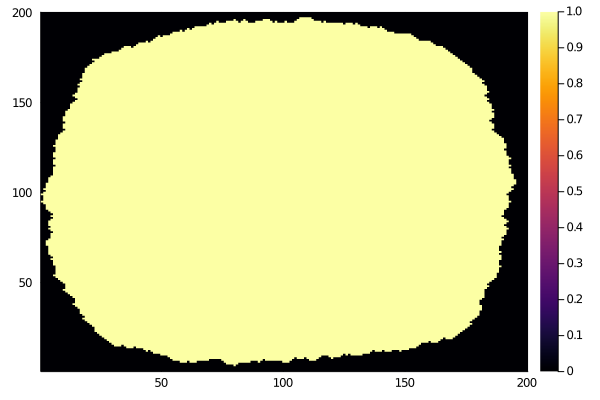

In [301]:
## random checkerboard from above
N = 200
B = fill(0,N,N)
box1 = [3 3 2 3; 3 2 3 2; 2 2 3 3 ; 3 3 2 2]
box2 = [2 2 2 2; 2 2 2 2; 2 3 2 2 ; 2 2 3 2]
p = 3/4

for x in 1:N 
    for y in 1:N 
        xx = (x)%4+1;
        yy = (y)%4+1;
        if(rand() < p)
            B[x,y] = box1[xx,yy]
        else
            B[x,y] = box2[xx,yy]
        end
    end
end
T = topple_end_wave(B)
heatmap(T.>0) #support of the odometer

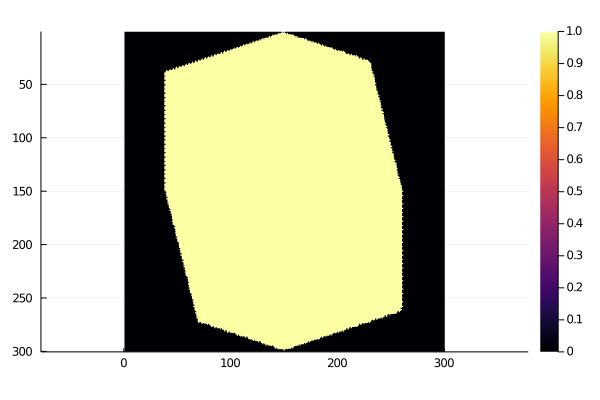

In [302]:
## compute shapes from Table 1 in the paper
N = 300
B = fill(0,N,N)
## comment in the box you want
#box = [3]; 
#box = [2 3; 3 2];
#box = [3 2 3; 2 3 3; 3 2 3];
box = [2 2 3 3; 3 2 3 2;2 3 2 2; 2 2 3 2];
#box = [3 2 3 3 3; 2 2 3 3 3; 2 2 3 2 2; 3 3 2 2 2; 3 3 3 2 3];

for x in 1:N 
    for y in 1:N 
        xx = (x)%size(box,1)+1;
        yy = (y)%size(box,2)+1;
        B[x,y] = box[xx,yy]
    end
end
T = topple_end_wave(B)
heatmap(T.>0, aspect_ratio=true, yflip = true) #support of the odometer